In [303]:
import pandas as pd

In [304]:
X_train: pd.DataFrame = pd.read_csv("../../X_train.csv")
X_train = X_train.to_numpy()
y_train: pd.DataFrame = pd.read_csv("../../y_train.csv")
y_train = y_train.to_numpy().reshape(-1)

In [305]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# general preprocessing of features

def threshold_variance(this_X, threshold=0.1):
    # remove low variance
    variance_selector = VarianceThreshold(threshold=threshold)
    X_reduced = variance_selector.fit_transform(this_X)

    # optionally scale after thresholding
    # X_scaled = StandardScaler().fit_transform(X_reduced)

    print(f"Threshold variance removed {this_X.shape[1] - X_reduced.shape[1]} features with threshold {threshold}")
    return X_reduced

In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression

def correlation_feature_selection(this_X, threshold=0.8, method='pearson', plot=True, feature_names=None):
    """
    Select features based on correlation analysis.

    Parameters:
    -----------
    X : array-like or DataFrame of shape (n_samples, n_features)
        The input samples.
    threshold : float, default=0.8
        Features with correlation higher than this threshold will be considered for removal.
    method : {'pearson', 'kendall', 'spearman'}, default='pearson'
        Correlation method to use.
    plot : bool, default=True
        Whether to plot the correlation matrix.
    feature_names : list or None, default=None
        Names of features for plotting.

    Returns:
    --------
    selected_features : ndarray
        Indices of selected features.
    """
    # convert to df
    # feature names do not hold significance at this stage
    if isinstance(this_X, np.ndarray):
        if feature_names is None:
            feature_names = [str(i) for i in range(this_X.shape[1])]
        X_df = pd.DataFrame(this_X, columns=feature_names)
    else:
        X_df = this_X.copy()
        feature_names = X_df.columns.tolist()

    corr_matrix = X_df.corr(method=method).abs()

    if plot:
        plt.figure(figsize=(20, 16))  # Increase figure size
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False,
                    square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
        plt.xticks(rotation=90, ha='right')  # Rotate x-labels 90 degrees
        plt.tight_layout()
        plt.title('Feature Correlation Matrix')
        plt.show()

    # upper triangle of correlation matrix
    # ignore diagonal comparison
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    to_drop = set()

    for col in upper_triangle.columns:
        if col in to_drop:
            continue

        highly_correlated = upper_triangle[col][upper_triangle[col] > threshold].index.tolist()

        for correlated_feature in highly_correlated:
            if correlated_feature not in to_drop: # also check this feature isn't dropped already
                # Calculate mean absolute correlation for both features
                # (how correlated they are with all other features)
                mean_corr_col = upper_triangle[col].mean()
                mean_corr_feature = upper_triangle[correlated_feature].mean()

                # Remove the one with higher mean correlation
                # (it's more redundant with other features)
                if mean_corr_col > mean_corr_feature:
                    to_drop.add(col)
                    break  # exit early
                else:
                    to_drop.add(correlated_feature)

    to_keep = [int(x) for x in feature_names if x not in to_drop]

    print(f"Correlation feature selection removed {len(to_drop)} features with correlations > {threshold}")
    return this_X[:, np.array(to_keep)]

In [307]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

def lasso_regularisation(this_X, this_y, alpha=0.01):
    # scale just for lasso
    X_scaled = StandardScaler().fit_transform(this_X)

    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_scaled, this_y)
    this_selected_features = np.where(np.abs(lasso.coef_) > 0)[0]
    X_reduced = this_X[:, this_selected_features]
    print(f"lasso regularisation removed {this_X.shape[1] - len(this_selected_features)} features")
    return X_reduced

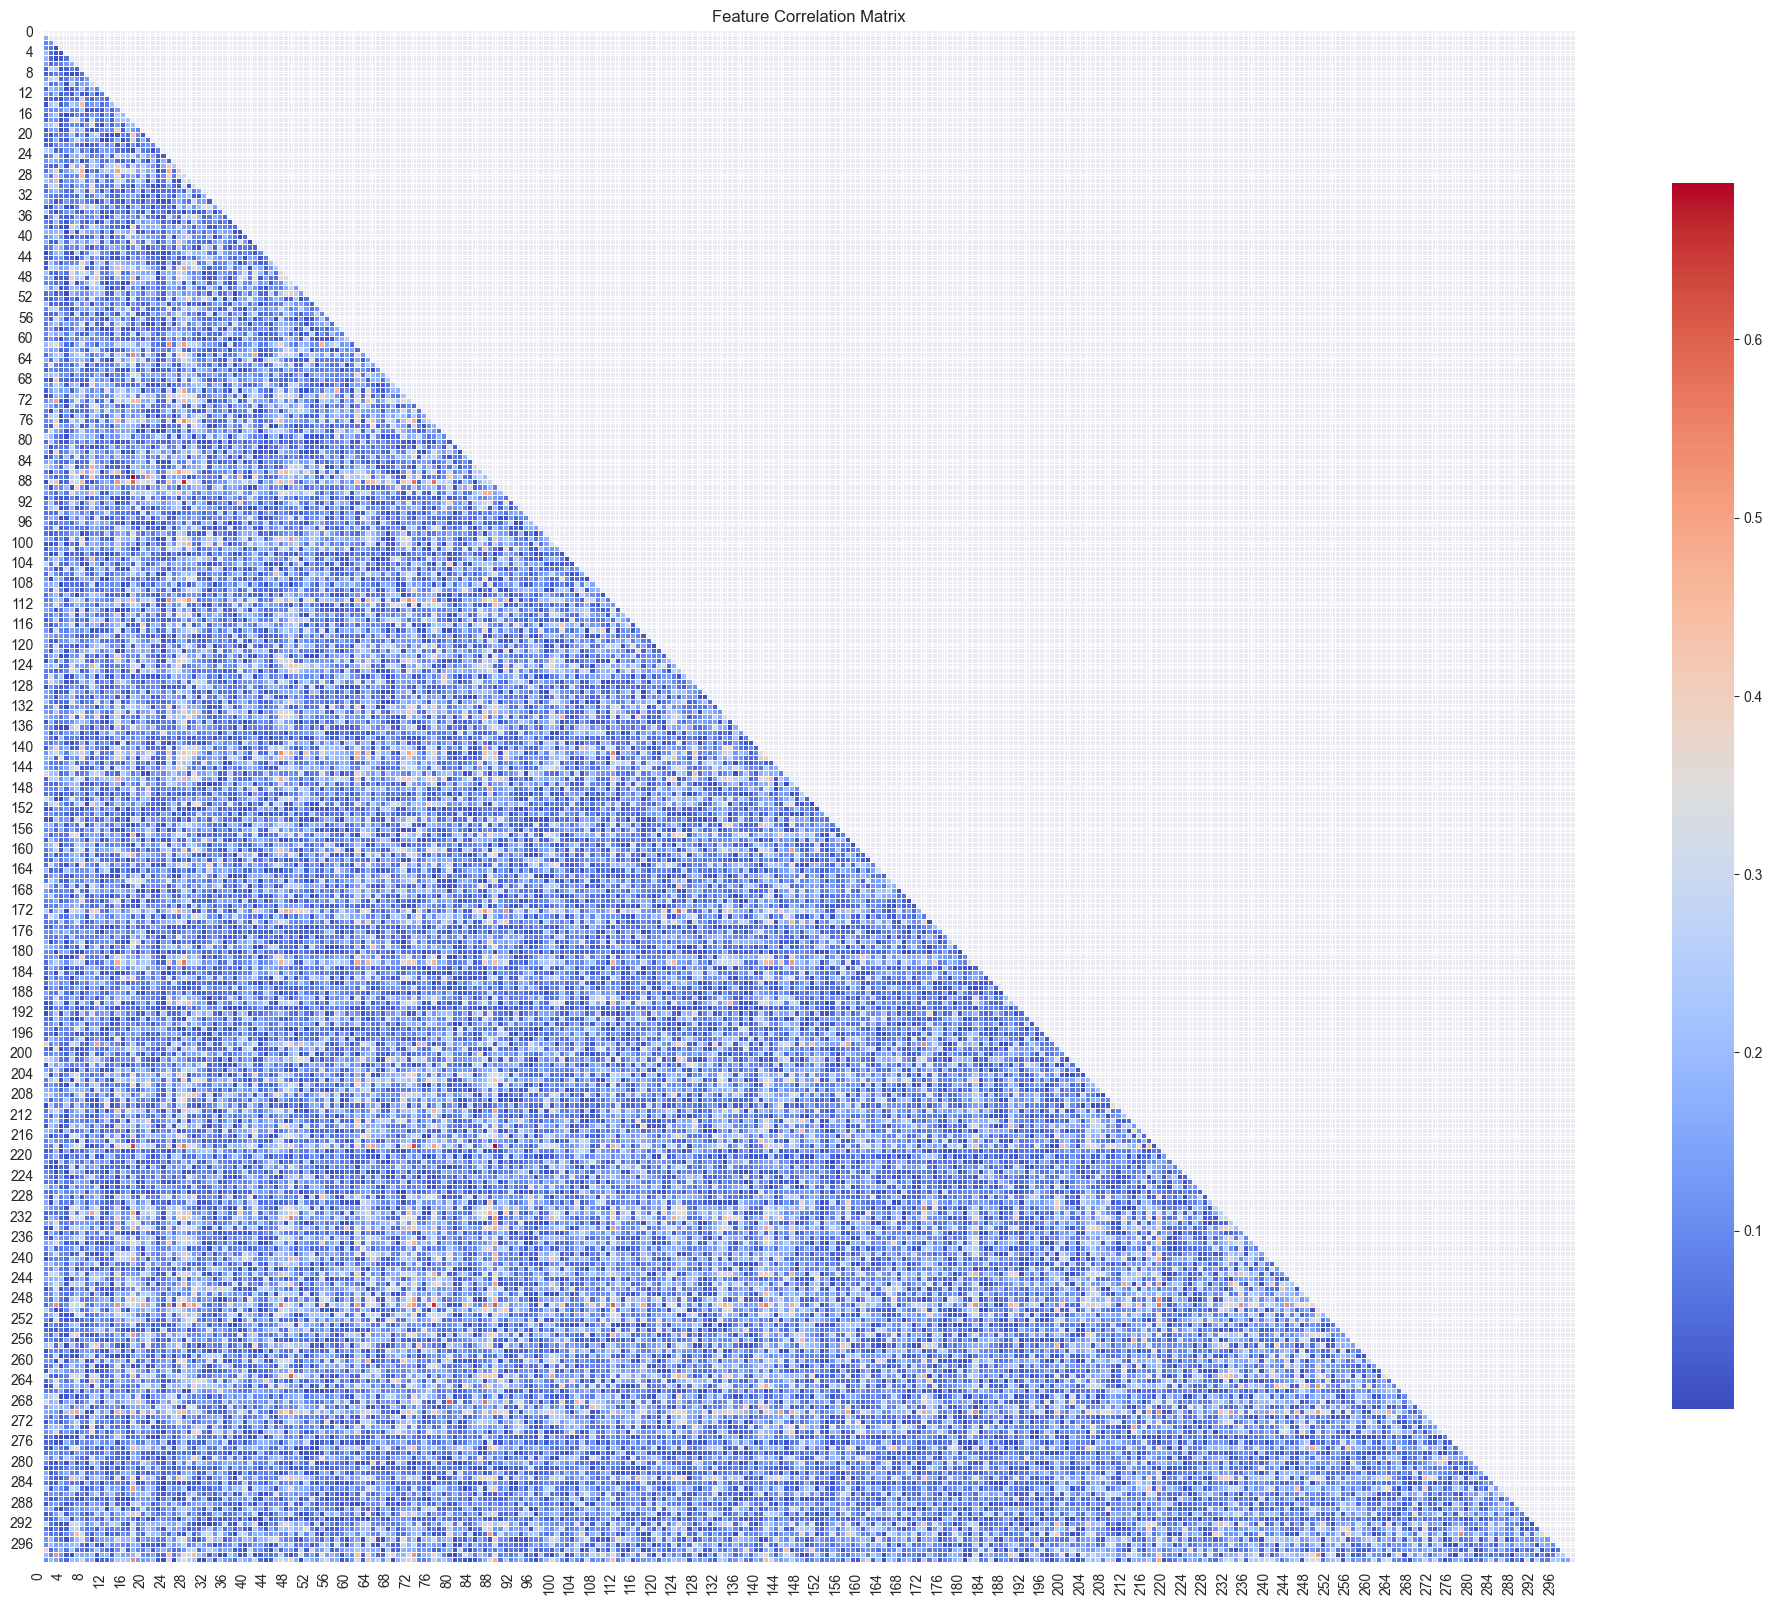

Correlation feature selection removed 0 features with correlations > 0.7
Threshold variance removed 0 features with threshold 0.7
lasso regularisation removed 145 features


In [308]:
X_train = correlation_feature_selection(X_train, plot=True, threshold=0.7)

X_train = threshold_variance(X_train, threshold=0.7)

X_train = lasso_regularisation(X_train, y_train, alpha=0.05) # moderate regularisation

In [309]:
# bfs = BayesianFeatureSelection(max_features=5, prior_type='binomial',
# 							   prior_params={'p': 0.3})
# bfs.fit(X_train, y_train)
# bfs.get_feature_importance()
# bfs.plot_feature_importance()

Even with more extreme thresholds, correlation is low and variance is high, so the space doesn't get reduced.

Best results were with lasso regularisation, which removes around half the features.

In [310]:
# try DeepFS

